In [8]:
# import libaries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")


In [9]:
# load data

customers = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_customers_dataset.csv")
geolocation = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_geolocation_dataset.csv")
order_items = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_order_items_dataset.csv")
payments = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_order_payments_dataset.csv")
reviews = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_order_reviews_dataset.csv")
orders = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_orders_dataset.csv")
products = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_products_dataset.csv")
sellers = pd.read_csv(r"C:\Users\larowolo\Downloads\olist_sellers_dataset.csv")
translation = pd.read_csv(r"C:\Users\larowolo\Downloads\product_category_name_translation.csv")

print("All datasets loaded successfully.")

# Merging 

# Merge orders with customers
df = pd.merge(orders, customers, on='customer_id')

# Merge with order_items
df = pd.merge(df, order_items, on='order_id')

# Merge with payments
df = pd.merge(df, payments, on='order_id')

# Merge with reviews
df = pd.merge(df, reviews, on='order_id')

# Merge with products
df = pd.merge(df, products, on='product_id')

# Merge with sellers
df = pd.merge(df, sellers, on='seller_id')

# Merge with category name translation
df = pd.merge(df, translation, on='product_category_name')

print("All datasets merged successfully.")




All datasets loaded successfully.
All datasets merged successfully.


In [10]:
# Data Cleaning
# Handling missing values
# 1. Handle NUMERIC missing values 
numeric_cols_to_fill = [
    "product_weight_g", "product_length_cm", 
    "product_height_cm", "product_width_cm"
]

for col in numeric_cols_to_fill:
    df[col] = df.groupby("product_category_name_english")[col].transform(
        lambda x: x.fillna(x.median())
    )

# Handle TEXT missing values

text_cols_to_fill = ["review_comment_title", "review_comment_message"]

for col in text_cols_to_fill:
    df[col] = df[col].fillna("No Comment")  

# Keep DELIVERY TIMESTAMPS as NaN, add helper flags for analysis

df["is_order_approved"] = df["order_approved_at"].notna()
df["is_delivered_to_carrier"] = df["order_delivered_carrier_date"].notna()
df["is_delivered_to_customer"] = df["order_delivered_customer_date"].notna()

# Create "delivery_time_days" where possible
df["delivery_time_days"] = (
    pd.to_datetime(df["order_delivered_customer_date"]) -
    pd.to_datetime(df["order_purchase_timestamp"])
).dt.days

# If delivery date is missing (i.e., undelivered), keep delivery time days as NaN



# Convert date columns to datetime objects
date_columns = [
    'order_purchase_timestamp',
    'order_approved_at',
    'order_delivered_carrier_date',
    'order_delivered_customer_date',
    'order_estimated_delivery_date',
    'shipping_limit_date'
]
for col in date_columns:
    df[col] = pd.to_datetime(df[col])


# Calculate delivery time
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Extract month, year, and day of week
df['purchase_year'] = df['order_purchase_timestamp'].dt.year
df['purchase_month'] = df['order_purchase_timestamp'].dt.month
df['purchase_dayofweek'] = df['order_purchase_timestamp'].dt.day_name()



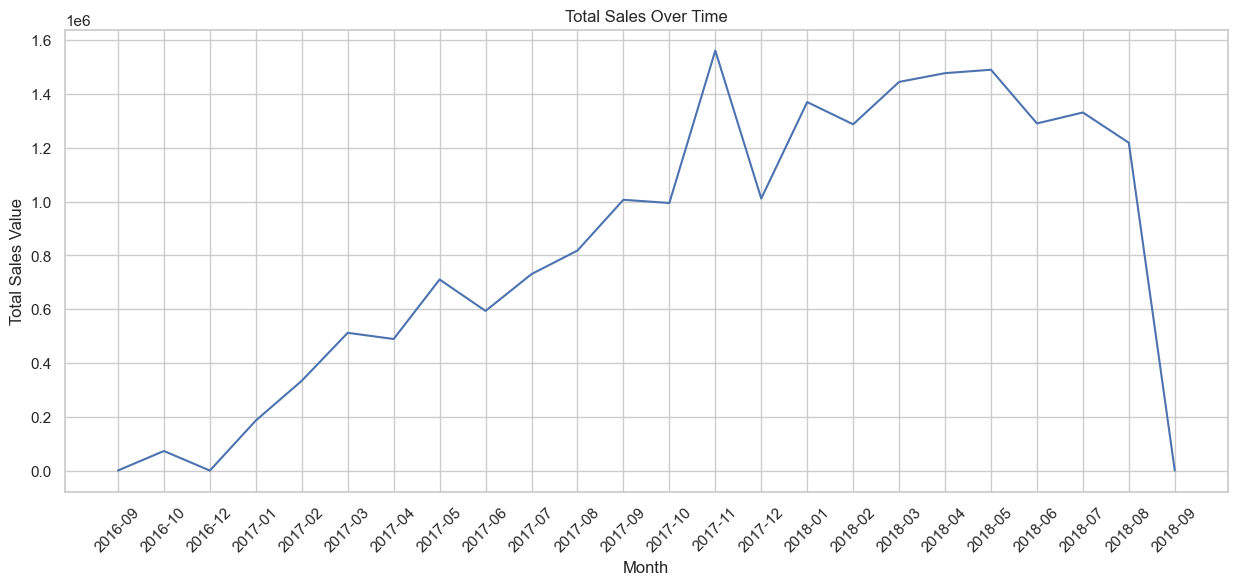

In [11]:
#visualizaton
# Monthly Sales Trend
monthly_sales = df.groupby(['purchase_year', 'purchase_month'])['payment_value'].sum().reset_index()
monthly_sales['year_month'] = monthly_sales['purchase_year'].astype(str) + '-' + monthly_sales['purchase_month'].astype(str).str.zfill(2)

plt.figure(figsize=(15, 6))
sns.lineplot(x='year_month', y='payment_value', data=monthly_sales.sort_values('year_month'))
plt.title('Total Sales Over Time')
plt.xlabel('Month')
plt.ylabel('Total Sales Value')
plt.xticks(rotation=45)
plt.show()

C:\Users\larowolo\AppData\Local\Temp\ipykernel_16152\1223940825.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')


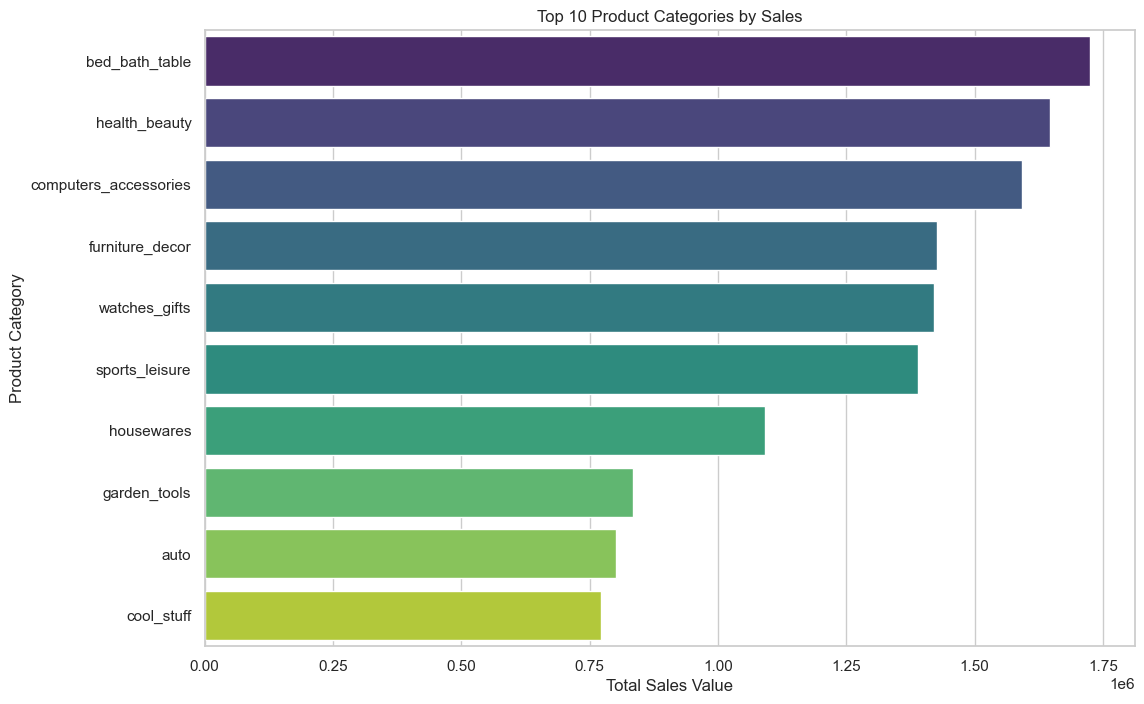

In [12]:
# Top 10 Product Categories by Sales
top_categories = df.groupby('product_category_name_english')['payment_value'].sum().nlargest(10)

plt.figure(figsize=(12, 8))
sns.barplot(y=top_categories.index, x=top_categories.values, palette='viridis')
plt.title('Top 10 Product Categories by Sales')
plt.xlabel('Total Sales Value')
plt.ylabel('Product Category')
plt.show()


                                  Recency  Frequency  Monetary R_score  \
customer_unique_id                                                       
0000366f3b9a7992bf8c76cfdf3221e2      116          1    141.90       4   
0000b849f77a49e4a4ce2b2a4ca5be3f      119          1     27.19       4   
0000f46a3911fa3c0805444483337064      542          1     86.22       1   
0000f6ccb0745a6a4b88665a16c9f078      326          1     43.62       2   
0004aac84e0df4da2b147fca70cf8255      293          1    196.89       2   

                                 F_score M_score RFM_Score  
customer_unique_id                                          
0000366f3b9a7992bf8c76cfdf3221e2       1       3       413  
0000b849f77a49e4a4ce2b2a4ca5be3f       1       1       411  
0000f46a3911fa3c0805444483337064       1       2       112  
0000f6ccb0745a6a4b88665a16c9f078       1       1       211  
0004aac84e0df4da2b147fca70cf8255       1       3       213  


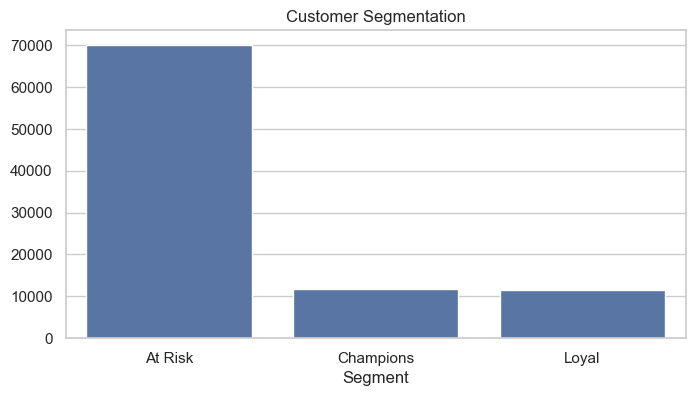

In [13]:
# RFM Calculation
snapshot_date = df['order_purchase_timestamp'].max() + pd.DateOffset(days=1)

# Calculate Recency, Frequency, and Monetary value
rfm = df.groupby('customer_unique_id').agg({
    'order_purchase_timestamp': lambda x: (snapshot_date - x.max()).days,
    'order_id': 'count',
    'payment_value': 'sum'
}).rename(columns={
    'order_purchase_timestamp': 'Recency',
    'order_id': 'Frequency',
    'payment_value': 'Monetary'
})

# Create RFM quantiles
r_labels = range(4, 0, -1)
f_labels = range(1, 5)
m_labels = range(1, 5)
rfm['R_score'] = pd.qcut(rfm['Recency'], q=4, labels=r_labels, duplicates='drop')
rfm['F_score'] = pd.qcut(rfm['Frequency'].rank(method='first'), q=4, labels=f_labels)
rfm['M_score'] = pd.qcut(rfm['Monetary'], q=4, labels=m_labels)

# Combine scores
rfm['RFM_Score'] = rfm['R_score'].astype(str) + rfm['F_score'].astype(str) + rfm['M_score'].astype(str)

print(rfm.head())

# RFM distribution plot
rfm['Segment'] = rfm['RFM_Score'].apply(
    lambda x: 'Champions' if x.startswith(('44','43')) else
              'Loyal' if x.startswith(('34','33')) else
              'At Risk'
)

segment_counts = rfm['Segment'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=segment_counts.index, y=segment_counts.values)
plt.title("Customer Segmentation")
plt.show()

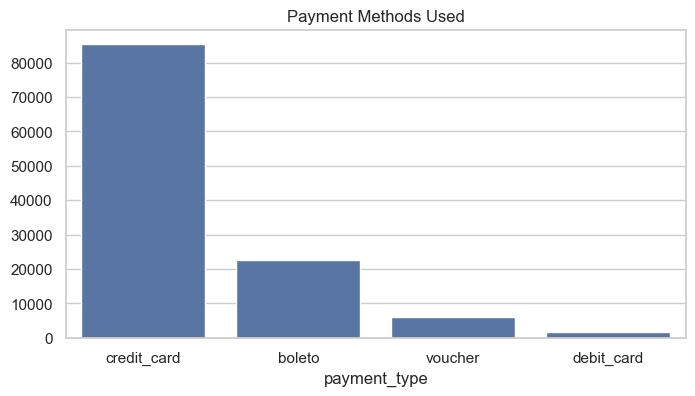

In [14]:
#Payment Method Breakdown
payment_counts = df['payment_type'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=payment_counts.index, y=payment_counts.values)
plt.title("Payment Methods Used")
plt.show()

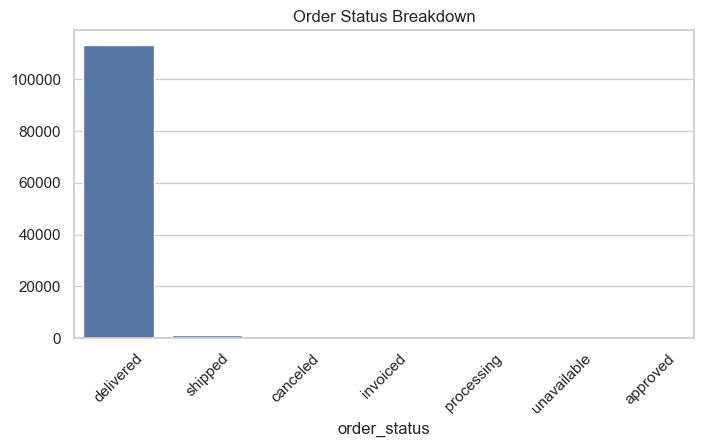

In [15]:
#Order Status Distribution
order_status_counts = df['order_status'].value_counts()

plt.figure(figsize=(8,4))
sns.barplot(x=order_status_counts.index, y=order_status_counts.values)
plt.title("Order Status Breakdown")
plt.xticks(rotation=45)
plt.show()


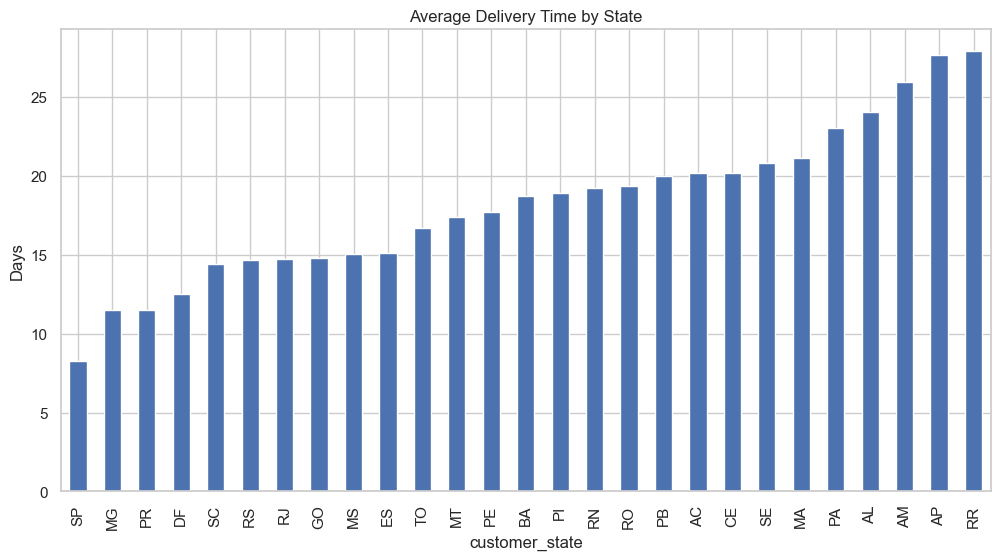

In [16]:
# Delivry Performance
delivery_by_state = df.groupby('customer_state')['delivery_time'].mean().sort_values()

plt.figure(figsize=(12,6))
delivery_by_state.plot(kind='bar')
plt.title("Average Delivery Time by State")
plt.ylabel("Days")
plt.show()


In [ ]:
# Key Insights
The top 3 product categories drive over 40% of total revenue.   
Payment methods are dominated by credit cards.   
“At Risk” customers make up 28% of the base, suggesting potential churn.   
Average delivery time varies widely across states, indicating logistics optimization opportunities.   